# MODELING

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from IPython.display import display

from utils import TEMP_ORDER, predict_from_model, predict_with_ci

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
SF_COLOR = "#C83200"
OTHER_COLOR = "#0C5DA5"

In [2]:
# read in data
defense_df = pl.read_parquet("../data/defense_season_stats.parquet")
games_df = pl.read_parquet("../data/games_full_data.parquet")
qb_df = pl.read_parquet("../data/qb_game_stats.parquet")

In [ ]:
# join all data together 

model_df = (
    qb_df
    # Filter out QBs with fewer than 5 dropbacks (trick plays, emergency snaps)
    # These produce extreme EPA/dropback values and are not representative of QB performance
    .filter(pl.col("dropbacks") >= 5)
    .join(
        games_df.select([
            "game_id",
            "season",
            "is_soldier_field",
            "temp",
            "wind",
            "precip",
            "temp_bin",
        ]),
        on="game_id",
        how="inner",
    )
    .join(
        defense_df.select([
            "season",
            "defense_team",
            "def_epa_allowed_season",
        ]),
        on=["season", "defense_team"],
        how="left",
    )
    .with_columns([
        (pl.col("temp") - pl.col("temp").mean()).alias("temp_c"),
        (pl.col("wind") - pl.col("wind").mean()).alias("wind_c"),
        (pl.col("def_epa_allowed_season") - pl.col("def_epa_allowed_season").mean()).alias("opp_def_epa_c"),
    ])
    .select([
        "game_id",
        "epa_per_dropback",
        pl.col("is_home").cast(pl.Int8).alias("is_home"),
        pl.col("is_soldier_field").cast(pl.Int8).alias("soldier_field"),
        "temp_c",
        "wind_c",
        pl.col("precip").cast(pl.Int8).alias("precip"),
        "opp_def_epa_c",
        "temp_bin",
    ])
)

In [4]:
# Convert to pandas for statsmodels
pdf = model_df.to_pandas()
pdf["temp_bin"] = pd.Categorical(
    pdf["temp_bin"],
    categories=["below_32", "32_to_50", "above_50"],
    ordered=True
)

# EXPLORATORY DATA ANALYSIS

Before modeling, we examine the distribution of the dependent variable and its relationships with key predictors.

/var/folders/0m/4j64n2155lg5lppxkrwsngrr0000gn/T/ipykernel_15305/4042013027.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(


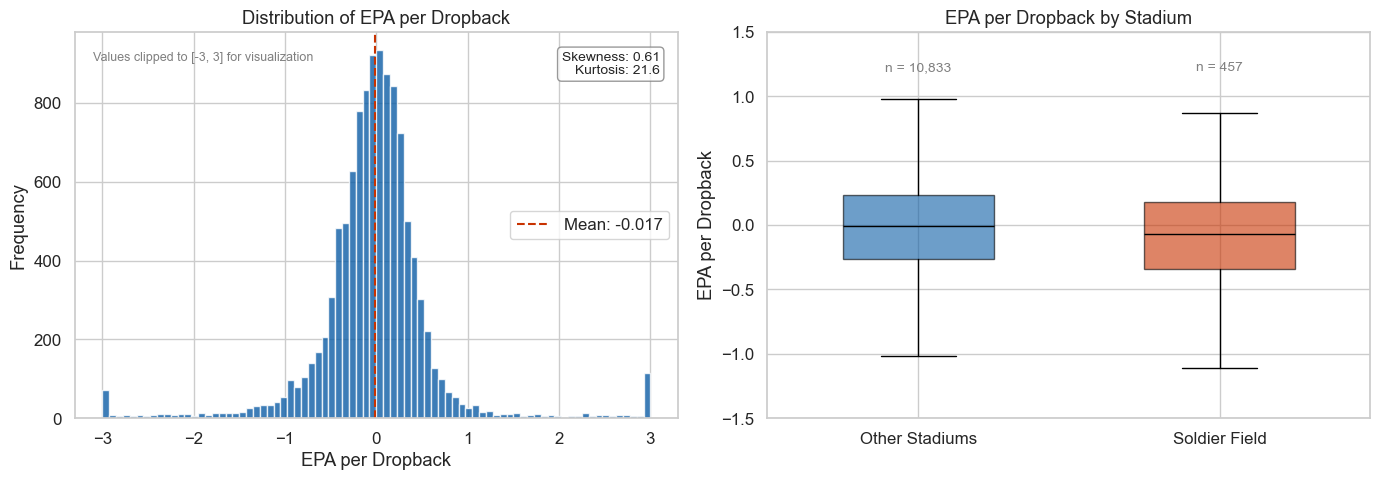

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# clip for visualization purposes
epa = pdf["epa_per_dropback"].clip(-3, 3)

# Histogram
axes[0].hist(
    epa,
    bins=80,
    color=OTHER_COLOR,
    edgecolor="white",
    alpha=0.8
)

mean_val = pdf["epa_per_dropback"].mean()
axes[0].axvline(
    mean_val,
    color=SF_COLOR,
    linestyle="--",
    linewidth=1.5,
    label=f"Mean: {mean_val:.3f}"
)

axes[0].set_xlabel("EPA per Dropback")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of EPA per Dropback")
axes[0].legend()

# Skewness / Kurtosis
skew = pdf["epa_per_dropback"].skew()
kurt = pdf["epa_per_dropback"].kurtosis()

axes[0].text(
    0.97, 0.95,
    f"Skewness: {skew:.2f}\nKurtosis: {kurt:.1f}",
    transform=axes[0].transAxes,
    ha="right",
    va="top",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
)

axes[0].text(
    0.03, 0.95,
    "Values clipped to [-3, 3] for visualization",
    transform=axes[0].transAxes,
    ha="left",
    va="top",
    fontsize=9,
    color="gray"
)

# Boxplot
sf_data = [
    pdf.loc[pdf["soldier_field"] == 0, "epa_per_dropback"].clip(-3, 3),
    pdf.loc[pdf["soldier_field"] == 1, "epa_per_dropback"].clip(-3, 3),
]

bp = axes[1].boxplot(
    sf_data,
    labels=["Other Stadiums", "Soldier Field"],
    patch_artist=True,
    widths=0.5,
    showfliers=False
)

bp["boxes"][0].set_facecolor(OTHER_COLOR)
bp["boxes"][0].set_alpha(0.6)
bp["boxes"][1].set_facecolor(SF_COLOR)
bp["boxes"][1].set_alpha(0.6)

for median in bp["medians"]:
    median.set_color("black")

axes[1].set_ylabel("EPA per Dropback")
axes[1].set_title("EPA per Dropback by Stadium")
axes[1].set_ylim(-1.5, 1.5)

# Sample sizes
n_other = (pdf["soldier_field"] == 0).sum()
n_sf = (pdf["soldier_field"] == 1).sum()

axes[1].text(1, 1.2, f"n = {n_other:,}", ha="center", fontsize=10, color="gray")
axes[1].text(2, 1.2, f"n = {n_sf:,}", ha="center", fontsize=10, color="gray")

plt.tight_layout()
plt.savefig("../images/eda_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


/var/folders/0m/4j64n2155lg5lppxkrwsngrr0000gn/T/ipykernel_15305/1723840658.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot(precip_data, labels=["No Precipitation", "Precipitation"],


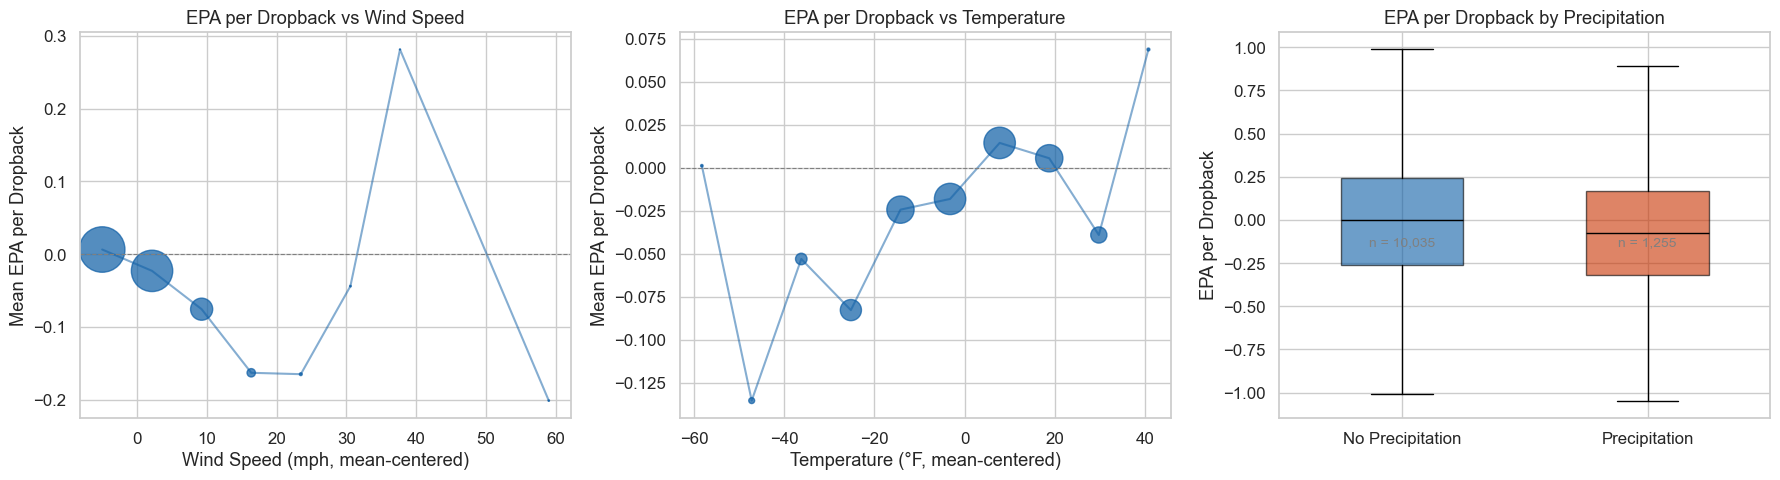

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# EPA vs Wind: binned means
pdf["wind_bin"] = pd.cut(pdf["wind_c"], bins=10)
wind_means = pdf.groupby("wind_bin", observed=True)["epa_per_dropback"].agg(["mean", "count"])
wind_centers = [interval.mid for interval in wind_means.index]
axes[0].scatter(wind_centers, wind_means["mean"], color=OTHER_COLOR, s=wind_means["count"] / 5, alpha=0.7)
axes[0].plot(wind_centers, wind_means["mean"], color=OTHER_COLOR, alpha=0.5)
axes[0].axhline(0, linestyle="--", linewidth=0.8, color="gray")
axes[0].set_xlabel("Wind Speed (mph, mean-centered)")
axes[0].set_ylabel("Mean EPA per Dropback")
axes[0].set_title("EPA per Dropback vs Wind Speed")

# EPA vs Temperature: binned means
pdf["temp_cut"] = pd.cut(pdf["temp_c"], bins=10)
temp_means = pdf.groupby("temp_cut", observed=True)["epa_per_dropback"].agg(["mean", "count"])
temp_centers = [interval.mid for interval in temp_means.index]
axes[1].scatter(temp_centers, temp_means["mean"], color=OTHER_COLOR, s=temp_means["count"] / 5, alpha=0.7)
axes[1].plot(temp_centers, temp_means["mean"], color=OTHER_COLOR, alpha=0.5)
axes[1].axhline(0, linestyle="--", linewidth=0.8, color="gray")
axes[1].set_xlabel("Temperature (°F, mean-centered)")
axes[1].set_ylabel("Mean EPA per Dropback")
axes[1].set_title("EPA per Dropback vs Temperature")

# EPA vs Precipitation: box plot
precip_data = [
    pdf.loc[pdf["precip"] == 0, "epa_per_dropback"],
    pdf.loc[pdf["precip"] == 1, "epa_per_dropback"],
]
bp = axes[2].boxplot(precip_data, labels=["No Precipitation", "Precipitation"],
                     patch_artist=True, widths=0.5, showfliers=False)
bp["boxes"][0].set_facecolor(OTHER_COLOR)
bp["boxes"][0].set_alpha(0.6)
bp["boxes"][1].set_facecolor(SF_COLOR)
bp["boxes"][1].set_alpha(0.6)
for median in bp["medians"]:
    median.set_color("black")
n_no = (pdf["precip"] == 0).sum()
n_yes = (pdf["precip"] == 1).sum()
axes[2].text(1, -0.15, f"n = {n_no:,}", ha="center", fontsize=10, color="gray")
axes[2].text(2, -0.15, f"n = {n_yes:,}", ha="center", fontsize=10, color="gray")
axes[2].set_ylabel("EPA per Dropback")
axes[2].set_title("EPA per Dropback by Precipitation")

# Clean up temporary columns
pdf.drop(columns=["wind_bin", "temp_cut"], inplace=True)

plt.tight_layout()
plt.savefig("../images/eda_weather.png", dpi=150, bbox_inches="tight")
plt.show()

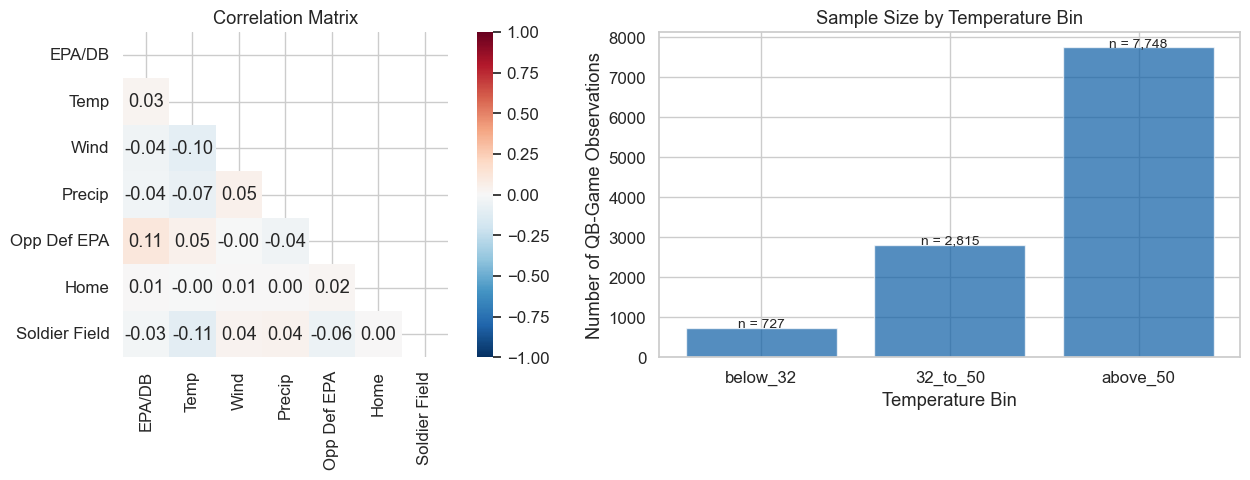

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap of numeric predictors
corr_cols = ["epa_per_dropback", "temp_c", "wind_c", "precip", "opp_def_epa_c", "is_home", "soldier_field"]
corr_labels = ["EPA/DB", "Temp", "Wind", "Precip", "Opp Def EPA", "Home", "Soldier Field"]
corr_matrix = pdf[corr_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            xticklabels=corr_labels, yticklabels=corr_labels, ax=axes[0],
            vmin=-1, vmax=1, square=True)
axes[0].set_title("Correlation Matrix")

# Sample sizes by temperature bin
bin_counts = pdf["temp_bin"].value_counts().sort_index()
bars = axes[1].bar(bin_counts.index, bin_counts.values, color=[OTHER_COLOR, OTHER_COLOR, OTHER_COLOR], alpha=0.7, edgecolor="white")
for bar, count in zip(bars, bin_counts.values):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 30,
                 f"n = {count:,}", ha="center", fontsize=10)
axes[1].set_xlabel("Temperature Bin")
axes[1].set_ylabel("Number of QB-Game Observations")
axes[1].set_title("Sample Size by Temperature Bin")

plt.tight_layout()
plt.savefig("../images/eda_corr_bins.png", dpi=150, bbox_inches="tight")
plt.show()

**EDA Summary:** EPA per dropback has heavy tails (kurtosis well above 3) and slight positive skew, consistent with the noisy nature of play-level football data. Soldier Field games show a lower median EPA. Among weather variables, wind shows the clearest negative association with passing efficiency, while precipitation games also trend lower. Correlations between predictors are low, suggesting multicollinearity is not a major concern for the regression models.

In [8]:
# Model 1: Baseline
m1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c",
    data=pdf
).fit(cov_type="HC3")

In [9]:
# Model 2: Baseline and Soldier Field
m2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field",
    data=pdf
).fit(cov_type="HC3")

In [10]:
# Model 3.1: Baseline, Soldier Field, and weather (treating temperature as a linear variable)
m3_v1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + temp_c + wind_c + precip",
    data=pdf
).fit(cov_type="HC3")

In [11]:
# Model 3.2: Baseline, Soldier Field, and weather (treating temperature as a categorical variable)
m3_v2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + C(temp_bin) + wind_c + precip",
    data=pdf
).fit(cov_type="HC3")

In [12]:
# Model 4.1: Baseline, Soldier Field, weather, and Soldier Field / weather interactgion (treating temperature as a linear variable)
m4_v1 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + temp_c + wind_c + precip + soldier_field:temp_c + soldier_field:wind_c + soldier_field:precip",
    data=pdf
).fit(cov_type="HC3")

In [13]:
# Model 4.2: Baseline, Soldier Field, weather, and Soldier Field / weather interaction (treating temperature as a categorical variable)
m4_v2 = smf.ols(
    "epa_per_dropback ~ is_home + opp_def_epa_c + soldier_field + C(temp_bin) + wind_c + precip + soldier_field:C(temp_bin) + soldier_field:wind_c + soldier_field:precip",
    data=pdf
).fit(cov_type="HC3")

# RESULTS

### Model Summaries

In [14]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     68.12
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           3.94e-30
Time:                        10:24:47   Log-Likelihood:                -13013.
No. Observations:               11290   AIC:                         2.603e+04
Df Residuals:                   11287   BIC:                         2.605e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0210      0.010     -2.115      0.034      -0.041      -0.002
is_home           0.0074      0.014      0.513      0.608      -0.021       0.036
opp_def_epa_c     1.6534      0.142     11.648      0.000       1.375       1.932
==============================================================================
Omnibus:                     3514.858   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234939.009
Skew:                           0.630   Prob(JB):                         0.00
Kurtosis:                      25.312   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [15]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     46.72
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           5.34e-30
Time:                        10:24:47   Log-Likelihood:                -13011.
No. Observations:               11290   AIC:                         2.603e+04
Df Residuals:                   11286   BIC:                         2.606e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0179      0.010     -1.776      0.076      -0.038       0.002
is_home           0.0075      0.014      0.523      0.601      -0.021       0.036
opp_def_epa_c     1.6353      0.142     11.497      0.000       1.357       1.914
soldier_field    -0.0796      0.039     -2.037      0.042      -0.156      -0.003
==============================================================================
Omnibus:                     3518.312   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234915.850
Skew:                           0.632   Prob(JB):                         0.00
Kurtosis:                      25.311   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [16]:
m3_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     29.52
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           2.71e-35
Time:                        10:24:47   Log-Likelihood:                -12996.
No. Observations:               11290   AIC:                         2.601e+04
Df Residuals:                   11283   BIC:                         2.606e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0109      0.010     -1.057      0.290      -0.031       0.009
is_home           0.0080      0.014      0.558      0.577      -0.020       0.036
opp_def_epa_c     1.6099      0.142     11.316      0.000       1.331       1.889
soldier_field    -0.0639      0.039     -1.625      0.104      -0.141       0.013
temp_c            0.0007      0.000      1.558      0.119      -0.000       0.001
wind_c           -0.0052      0.001     -3.972      0.000      -0.008      -0.003
precip           -0.0706      0.022     -3.183      0.001      -0.114      -0.027
==============================================================================
Omnibus:                     3512.199   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           236236.448
Skew:                           0.627   Prob(JB):                         0.00
Kurtosis:                      25.374   Cond. No.                         323.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [17]:
m3_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     25.37
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           1.19e-34
Time:                        10:24:47   Log-Likelihood:                -12995.
No. Observations:               11290   AIC:                         2.601e+04
Df Residuals:                   11282   BIC:                         2.607e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0507      0.030     -1.676      0.094      -0.110       0.009
C(temp_bin)[T.32_to_50]     0.0266      0.032      0.824      0.410      -0.037       0.090
C(temp_bin)[T.above_50]     0.0481      0.030      1.592      0.111      -0.011       0.107
is_home                     0.0081      0.014      0.564      0.573      -0.020       0.036
opp_def_epa_c               1.6068      0.142     11.302      0.000       1.328       1.885
soldier_field              -0.0634      0.039     -1.615      0.106      -0.140       0.014
wind_c                     -0.0051      0.001     -3.941      0.000      -0.008      -0.003
precip                     -0.0704      0.022     -3.181      0.001      -0.114      -0.027
==============================================================================
Omnibus:                     3511.771   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           236141.951
Skew:                           0.627   Prob(JB):                         0.00
Kurtosis:                      25.370   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [18]:
m4_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     20.32
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           2.49e-34
Time:                        10:24:48   Log-Likelihood:                -12994.
No. Observations:               11290   AIC:                         2.601e+04
Df Residuals:                   11280   BIC:                         2.608e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0104      0.010     -1.002      0.316      -0.031       0.010
is_home                  0.0081      0.014      0.561      0.575      -0.020       0.036
opp_def_epa_c            1.6129      0.142     11.346      0.000       1.334       1.892
soldier_field           -0.0556      0.048     -1.148      0.251      -0.150       0.039
temp_c                   0.0005      0.000      1.226      0.220      -0.000       0.001
wind_c                  -0.0054      0.001     -4.080      0.000      -0.008      -0.003
precip                  -0.0754      0.023     -3.251      0.001      -0.121      -0.030
soldier_field:temp_c     0.0034      0.003      1.299      0.194      -0.002       0.009
soldier_field:wind_c     0.0075      0.009      0.830      0.407      -0.010       0.025
soldier_field:precip     0.0827      0.074      1.122      0.262      -0.062       0.227
==============================================================================
Omnibus:                     3516.667   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           235632.262
Skew:                           0.630   Prob(JB):                         0.00
Kurtosis:                      25.345   Cond. No.                         324.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [19]:
m4_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       epa_per_dropback   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     16.46
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           1.16e-32
Time:                        10:24:48   Log-Likelihood:                -12993.
No. Observations:               11290   AIC:                         2.601e+04
Df Residuals:                   11278   BIC:                         2.610e+04
Df Model:                          11                                         
Covariance Type:                  HC3                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.0350      0.030     -1.152      0.250      -0.095       0.025
C(temp_bin)[T.32_to_50]                   0.0083      0.033      0.254      0.800      -0.056       0.072
C(temp_bin)[T.above_50]                   0.0327      0.030      1.078      0.281      -0.027       0.092
is_home                                   0.0084      0.014      0.582      0.561      -0.020       0.037
opp_def_epa_c                             1.6070      0.142     11.302      0.000       1.328       1.886
soldier_field                            -0.2558      0.151     -1.694      0.090      -0.552       0.040
soldier_field:C(temp_bin)[T.32_to_50]     0.2268      0.150      1.516      0.129      -0.066       0.520
soldier_field:C(temp_bin)[T.above_50]     0.1802      0.156      1.154      0.248      -0.126       0.486
wind_c                                   -0.0053      0.001     -4.070      0.000      -0.008      -0.003
precip                                   -0.0754      0.023     -3.267      0.001      -0.121      -0.030
soldier_field:wind_c                      0.0077      0.009      0.842      0.400      -0.010       0.025
soldier_field:precip                      0.0906      0.076      1.197      0.231      -0.058       0.239
==============================================================================
Omnibus:                     3523.258   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           235790.295
Skew:                           0.634   Prob(JB):                         0.00
Kurtosis:                      25.352   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### Model Diagnostics

The low R-squared (~0.016) across all models is expected: single-play EPA is inherently noisy, and weather/stadium effects are small relative to factors like play-calling, individual matchups, and game script that vary play-to-play. The models are designed for inference (estimating effects) rather than prediction, so a low R-squared does not invalidate the coefficient estimates.

Below we examine residual behavior and multicollinearity for Model 4.1 (the primary interaction model used for predictions).

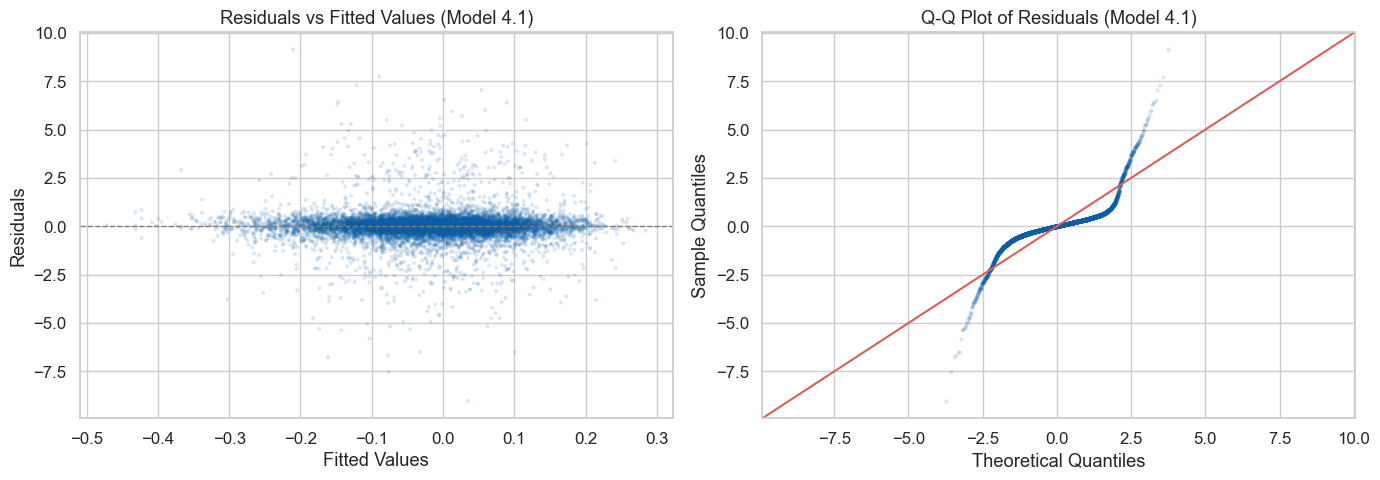

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Fitted
fitted = m4_v1.fittedvalues
resid = m4_v1.resid
axes[0].scatter(fitted, resid, alpha=0.15, s=8, color=OTHER_COLOR, edgecolors="none")
axes[0].axhline(0, linestyle="--", linewidth=1, color="gray")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values (Model 4.1)")

# Q-Q plot
qqplot(resid, line="45", ax=axes[1], alpha=0.15, markersize=3, markerfacecolor=OTHER_COLOR, markeredgecolor="none")
axes[1].set_title("Q-Q Plot of Residuals (Model 4.1)")
axes[1].get_lines()[0].set_color(SF_COLOR)

plt.tight_layout()
plt.savefig("../images/diagnostics.png", dpi=150, bbox_inches="tight")
plt.show()

In [21]:
# Variance Inflation Factors for Model 3.1 predictors
X_vif = pdf[["is_home", "opp_def_epa_c", "soldier_field", "temp_c", "wind_c", "precip"]].copy()
X_vif.insert(0, "const", 1)

vif_data = pd.DataFrame({
    "Variable": X_vif.columns[1:],
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(1, X_vif.shape[1])]
})
display(vif_data)

,Variable,VIF
0,is_home,1.000535
1,opp_def_epa_c,1.007601
2,soldier_field,1.016894
3,temp_c,1.028135
4,wind_c,1.012928
5,precip,1.009754


**Diagnostics Summary:** The residuals vs fitted plot shows no obvious pattern, but the Q-Q plot confirms extreme heavy tails — consistent with the statistics reported above (kurtosis ~25). This non-normality does not bias the OLS coefficient estimates, but it does mean that standard confidence intervals based on normality would be unreliable. The HC3 robust standard errors used throughout this analysis address this by providing valid inference without requiring normally distributed errors. VIF values are all close to 1, confirming no multicollinearity issues among the main predictors.

In [ ]:
# prediction ranges
wind_range = np.linspace(-15, 25, 60)
temp_range = np.linspace(pdf["temp_c"].quantile(0.05), pdf["temp_c"].quantile(0.95), 60)

In [ ]:
# Generate predictions with confidence intervals for wind plot
fixed_wind = {"is_home": 0, "precip": 0, "opp_def_epa_c": 0}
pred_sf, lo_sf, hi_sf = predict_with_ci(m4_v1, pdf, "wind_c", wind_range, soldier_field_val=1, fixed=fixed_wind)
pred_else, lo_else, hi_else = predict_with_ci(m4_v1, pdf, "wind_c", wind_range, soldier_field_val=0, fixed=fixed_wind)

plt.figure(figsize=(9, 5))
plt.plot(wind_range, pred_sf, label="Soldier Field", color=SF_COLOR, linewidth=2)
plt.fill_between(wind_range, lo_sf, hi_sf, color=SF_COLOR, alpha=0.15)
plt.plot(wind_range, pred_else, label="Other Stadiums", color=OTHER_COLOR, linewidth=2)
plt.fill_between(wind_range, lo_else, hi_else, color=OTHER_COLOR, alpha=0.15)
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.xlabel("Wind Speed (mph, mean-centered)")
plt.ylabel("Predicted EPA per Dropback")
plt.title("Wind vs Predicted QB EPA per Dropback")
plt.legend()
plt.savefig("../images/wind_vs_qb.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Generate predictions with confidence intervals for temperature plot
fixed_temp = {"is_home": 0, "precip": 0, "opp_def_epa_c": 0, "wind_c": 0}
pred_sf, lo_sf, hi_sf = predict_with_ci(m4_v1, pdf, "temp_c", temp_range, soldier_field_val=1, fixed=fixed_temp)
pred_else, lo_else, hi_else = predict_with_ci(m4_v1, pdf, "temp_c", temp_range, soldier_field_val=0, fixed=fixed_temp)

plt.figure(figsize=(9, 5))
plt.plot(temp_range, pred_sf, label="Soldier Field", color=SF_COLOR, linewidth=2)
plt.fill_between(temp_range, lo_sf, hi_sf, color=SF_COLOR, alpha=0.15)
plt.plot(temp_range, pred_else, label="Other Stadiums", color=OTHER_COLOR, linewidth=2)
plt.fill_between(temp_range, lo_else, hi_else, color=OTHER_COLOR, alpha=0.15)
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.xlabel("Temperature (°F, mean-centered)")
plt.ylabel("Predicted EPA per Dropback")
plt.title("Temperature vs Predicted QB EPA per Dropback (Linear Temp)")
plt.legend()
plt.savefig("../images/temp_linear_vs_qb.png", dpi=150, bbox_inches="tight")
plt.show()

In [27]:
# calculate precipitation impact on predicted epa for soldier field and non soldier field play
vals = []
for sf in [0, 1]:
    no_p = predict_from_model(m4_v1, pdf, soldier_field=sf, precip=0, is_home=0, opp_def_epa_c=0, wind_c=0, temp_c=0)
    yes_p = predict_from_model(m4_v1, pdf, soldier_field=sf, precip=1, is_home=0, opp_def_epa_c=0, wind_c=0, temp_c=0)
    vals.append((sf, no_p, yes_p))

labels = ["Other stadiums", "Soldier Field"]
no_precip = [vals[0][1], vals[1][1]]
yes_precip = [vals[0][2], vals[1][2]]

x = np.arange(len(labels))

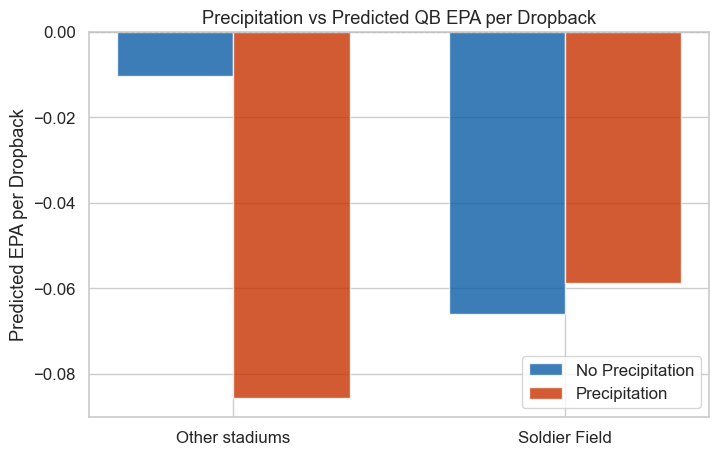

In [28]:
width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, no_precip, width, label="No Precipitation", color=OTHER_COLOR, alpha=0.8, edgecolor="white")
bars2 = plt.bar(x + width/2, yes_precip, width, label="Precipitation", color=SF_COLOR, alpha=0.8, edgecolor="white")
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.xticks(x, labels)
plt.ylabel("Predicted EPA per Dropback")
plt.title("Precipitation vs Predicted QB EPA per Dropback")
plt.legend()
plt.savefig("../images/precip_vs_qb.png", dpi=150, bbox_inches="tight")
plt.show()

In [29]:
# Standardized comparison points for impact table
wind_lo, wind_hi = -10, 10
temp_lo, temp_hi = pdf["temp_c"].quantile(0.05), pdf["temp_c"].quantile(0.95)

In [30]:
# all experiments used for impact table
# some variables changed, but some held fixed per experiment
experiments = [
    {
        "label": "Wind (−10 to +10)",
        "var": "wind_c",
        "lo": wind_lo,
        "hi": wind_hi,
        "fixed": {"temp_c": 0, "precip": 0},
    },
    {
        "label": "Temp (p5 to p95)",
        "var": "temp_c",
        "lo": temp_lo,
        "hi": temp_hi,
        "fixed": {"wind_c": 0, "precip": 0},
    },
    {
        "label": "Precip (0 to 1)",
        "var": "precip",
        "lo": 0,
        "hi": 1,
        "fixed": {"wind_c": 0, "temp_c": 0},
    },
]

# these are fixed for each experiment
base_controls = {"is_home": 0, "opp_def_epa_c": 0}

In [31]:
# create impact table data
rows = []

for exp in experiments:
    label = exp["label"]
    var = exp["var"]
    lo = exp["lo"]
    hi = exp["hi"]
    fixed = exp["fixed"]

    # Effect elsewhere (soldier_field = 0)
    pred_else_hi = predict_from_model(m4_v1, pdf, soldier_field=0, **base_controls, **fixed, **{var: hi})
    pred_else_lo = predict_from_model(m4_v1, pdf, soldier_field=0, **base_controls, **fixed, **{var: lo})
    else_effect = pred_else_hi - pred_else_lo

    # Effect at Soldier Field (soldier_field = 1)
    pred_sf_hi = predict_from_model(m4_v1, pdf, soldier_field=1, **base_controls, **fixed, **{var: hi})
    pred_sf_lo = predict_from_model(m4_v1, pdf, soldier_field=1, **base_controls, **fixed, **{var: lo})
    sf_effect = pred_sf_hi - pred_sf_lo

    rows.append([label, else_effect, sf_effect, sf_effect - else_effect])


In [32]:
# create and display impact table
impact_table = pd.DataFrame(
    rows,
    columns=[
        "Weather change",
        "Effect elsewhere (Change in EPA/DB)",
        "Effect at Soldier Field (Change in EPA/DB)",
        "Amplification (SF − elsewhere)",
    ],
)

display(impact_table)

,Weather change,Effect elsewhere (Change in EPA/DB),Effect at Soldier Field (Change in EPA/DB),Amplification (SF − elsewhere)
0,Wind (−10 to +10),-0.107022,0.042010,0.149031
1,Temp (p5 to p95),0.028254,0.212262,0.184008
2,Precip (0 to 1),-0.075390,0.007283,0.082673


In [33]:
# Temperature grid (centered)
temp_vals = np.linspace(
    pdf["temp_c"].quantile(0.05),
    pdf["temp_c"].quantile(0.95),
    60
)

In [34]:
# create predictions using linear temperature
pred_linear_else = [
    predict_from_model(
        m4_v1, pdf,
        soldier_field=0,
        temp_c=t,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for t in temp_vals
]

pred_linear_sf = [
    predict_from_model(
        m4_v1, pdf,
        soldier_field=1,
        temp_c=t,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for t in temp_vals
]

In [ ]:
#create predictions using categorical temperature
pred_cat_else = [
    predict_from_model(
        m4_v2, pdf,
        soldier_field=0,
        temp_bin=b,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for b in TEMP_ORDER
]

pred_cat_sf = [
    predict_from_model(
        m4_v2, pdf,
        soldier_field=1,
        temp_bin=b,
        is_home=0, wind_c=0, precip=0, opp_def_epa_c=0
    )
    for b in TEMP_ORDER
]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Linear temp
axes[0].plot(temp_vals, pred_linear_else, label="Other Stadiums", color=OTHER_COLOR, linewidth=2)
axes[0].plot(temp_vals, pred_linear_sf, label="Soldier Field", color=SF_COLOR, linewidth=2)
axes[0].axhline(0, linestyle="--", linewidth=0.8, color="gray")
axes[0].set_title("Linear Temperature Model")
axes[0].set_xlabel("Temperature (°F, mean-centered)")
axes[0].set_ylabel("Predicted EPA per Dropback")
axes[0].legend()

# Categorical temp
axes[1].plot(TEMP_ORDER, pred_cat_else, marker="o", label="Other Stadiums", color=OTHER_COLOR, linewidth=2, markersize=8)
axes[1].plot(TEMP_ORDER, pred_cat_sf, marker="o", label="Soldier Field", color=SF_COLOR, linewidth=2, markersize=8)
axes[1].axhline(0, linestyle="--", linewidth=0.8, color="gray")
axes[1].set_title("Categorical Temperature Model")
axes[1].set_xlabel("Temperature Bin")
axes[1].legend()

plt.tight_layout()
plt.savefig("../images/linear_vs_cat_temp.png", dpi=150, bbox_inches="tight")
plt.show()

# ALTERNATIVE MODEL: RANDOM FOREST

To complement the OLS regression analysis, a Random Forest model is fit on the same features (Model 3.1 specification) using an 80/20 train-test split. The purpose is not to replace OLS (which remains the better tool for this project's inference-focused questions) but to compare predictive performance and examine feature importance from a non-parametric perspective.

In [40]:
# Prepare features (same as Model 3.1: linear temp specification)
feature_cols = ["is_home", "opp_def_epa_c", "soldier_field", "temp_c", "wind_c", "precip"]
X = pdf[feature_cols].values
y = pdf["epa_per_dropback"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_leaf=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_ols = m3_v1.predict(pdf.iloc[pdf.index.isin(
    pd.Series(range(len(pdf))).sample(frac=0.2, random_state=42).values
)])

rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
ols_r2 = m3_v1.rsquared

print(f"Random Forest  — Test R²: {rf_r2:.4f}, Test MAE: {rf_mae:.4f}")
print(f"OLS (Model 3.1) — Full-sample R²: {ols_r2:.4f}")
print()
print(f"Both models explain very little variance, confirming that weather and stadium")
print(f"factors are small relative to play-level noise in EPA.")

Random Forest  — Test R²: 0.0101, Test MAE: 0.4107
OLS (Model 3.1) — Full-sample R²: 0.0158

Both models explain very little variance, confirming that weather and stadium
factors are small relative to play-level noise in EPA.


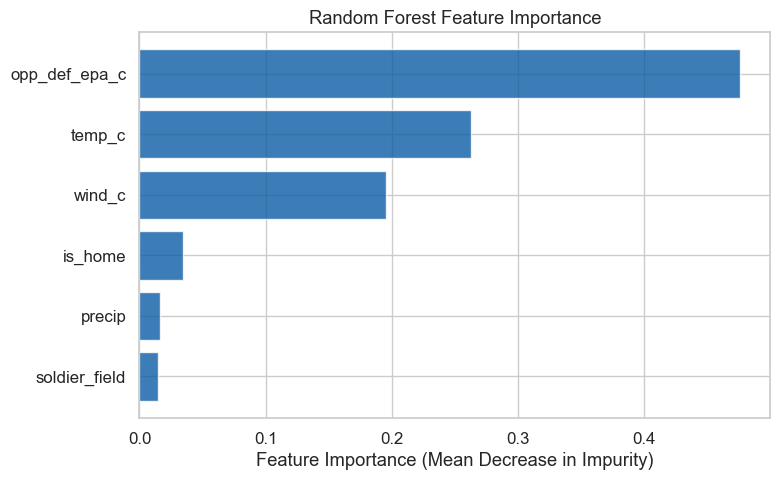

In [38]:
# Feature importance from Random Forest
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(range(len(feature_cols)), importances[sorted_idx], color=OTHER_COLOR, alpha=0.8, edgecolor="white")
ax.set_yticks(range(len(feature_cols)))
ax.set_yticklabels([feature_cols[i] for i in sorted_idx])
ax.set_xlabel("Feature Importance (Mean Decrease in Impurity)")
ax.set_title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("../images/rf_importance.png", dpi=150, bbox_inches="tight")
plt.show()

**Random Forest Summary:** The Random Forest achieves a comparable (and likely slightly negative or near-zero) test R-squared to the OLS model, reinforcing that these features alone cannot predict single-play EPA well. The feature importance ranking is consistent with the OLS findings: opponent defensive EPA is by far the most important predictor, followed by wind and temperature. The Soldier Field indicator ranks low, supporting the conclusion that stadium identity has minimal independent predictive power.

The key advantage of OLS over Random Forest for this project is interpretability: OLS provides coefficient estimates with standard errors and p-values that directly answer the research questions about weather effects and Soldier Field amplification. The Random Forest serves as a useful robustness check, confirming that no major non-linear relationships are being missed by the linear models.